<a href="https://colab.research.google.com/github/mauriciodev/spatialgeodesy/blob/main/notebooks/celestial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook illustrates the celestial to terrestrial coordinate convertion using a class that downloads data from IERS Bulletin B and uses ERFA python library to compute the rotation matrixes.

# Class for coordinate conversion

In [ ]:
import erfa
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd 

class celestial:
    
  def getRotationMatrix(self,t):
    year = t.astype('datetime64[Y]').astype(int) + 1970
    month = t.astype('datetime64[M]').astype(int) % 12 + 1
    day = ((t - t.astype('datetime64[M]')+1)/ np.timedelta64(1, 'D')).astype(int)
    t2=t+np.timedelta64(1,'D')
    year2 = t2.astype('datetime64[Y]').astype(int) + 1970
    month2 = t2.astype('datetime64[M]').astype(int) % 12 + 1
    day2 = ((t2 - t.astype('datetime64[M]')+1)/ np.timedelta64(1, 'D')).astype(int)
    print(year,month,day)
    df=self.getIERSBulletinB(year,month,day,year2,month2,day2)
    Xp=df.iloc[0]['x_pole[marcsec]']
    Yp=df.iloc[0]['y_pole[marcsec]']
    DUT1=df.iloc[0]['UT1-UTC[msec]']
    print(df.keys())
    #Boletin do IERS - posicao do polo
    XP = Xp*np.pi/648000.0;#em radianos
    YP = Yp*np.pi/648000.0;
    DUT1 = DUT1*np.pi/648000.0;
    tempo = (t - t.astype('datetime64[D]')).astype(int)
    #Calendario Gregoriano para Data Juliana
    aux=erfa.cal2jd(year, month, day)
    djm0,djm=aux

    #HORA UTC (DIFERE DA HORA GPS POR 13 SEGUNDOS)
    UTC = tempo-13.0;
    UT1 = UTC + DUT1;
    TAI = UTC + 32.0; #!TEMPO ATOMICO INTERNACIONAL
    TT = TAI + 32.184; #!TEMPO TERRESTRE

    DATA1 = djm0;
    DATA2 = djm + TT/(86400.0);

    DATE2UT1 = djm + UT1/(86400.0);
    rc2t=erfa.c2t00a(DATA1, DATA2, DATA1, DATE2UT1, XP, YP)
    return rc2t

  def terrestrial2celestial(self, RT,t):
    rc2t=self.getRotationMatrix(t)
    R_celestial=erfa.trxp(rc2t, RT) 
    return R_celestial

  def celestial2terrestrial(self, RT,t):
    rc2t=self.getRotationMatrix(t)
    R_celestial=erfa.rxp(rc2t, RT)  
    return R_celestial

  def getIERSBulletinB(self,year0,month0,day0,year1,month1,day1):
    pload = {"start_year": year0,
    "start_month": month0,
    "start_day": day0,
    "end_year": year1,
    "end_month": month1,
    "end_day": day1,
    "series[]": ["Bulletin B"],
    "parameter[]": ["x_pole","y_pole","UT1-UTC"],
    "vertical": "Submit"
    }
    baseurl="https://data.iers.org/eris/eopReader/php/"
    r = requests.post(baseurl+'readeop.php',data = pload)
    soup = BeautifulSoup(r.text, 'html.parser')
    filtered = filter(lambda text: text.get('href').find("generateCSV.php")>=0, soup.find_all("a"))
    filtered=list(filtered)
    csvFileUrl=baseurl+filtered[0].get('href')
    df=pd.read_csv(csvFileUrl,delimiter=";",parse_dates={'date':['Year','Month','Day']})
    df.dropna(inplace=True,subset=['date','x_pole[marcsec]','y_pole[marcsec]'])
    return df


# Testing the class

In [ ]:
#INPUT DATA
R_celestial=np.array([-2768.51568811, 16094.22351633, 21138.78918259])
t=np.datetime64('2015-05-02T10:02:01')

In [ ]:
test=celestial()
test.terrestrial2celestial(R_celestial,t)

print("Celestial coordinates (km):         ",R_celestial)
print("Expected celestial coordinates: (km)",[-2768.51569,	16094.22352,	21138.78919])


2015 5 1
Index(['date', 'Series', 'MJD', 'Type of Pole values', 'x_pole[marcsec]',
       'y_pole[marcsec]', 'Type of UT values', 'UT1-UTC[msec]',
       'Type of Nutation values', 'Unnamed: 11'],
      dtype='object')
Celestial coordinates (km):          [-2768.51568811 16094.22351633 21138.78918259]
Expected celestial coordinates: (km) [-2768.51569, 16094.22352, 21138.78919]


# IERS bulletin downloader (step by step)



In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

## Downloading data from IERS service and parsing as a dataframe

In [ ]:
pload = {"start_year": "1990",
"start_month": "01",
"start_day": "01",
"end_year": "2021",
"end_month": "01",
"end_day": "01",
"series[]": ["Bulletin B"],
"parameter[]": ["x_pole","y_pole","UT1-UTC"],
"vertical": "Submit"
}
baseurl="https://data.iers.org/eris/eopReader/php/"
#start_year=2021&start_month=01&start_day=01&end_year=2021&end_month=01&end_day=01&series%5B%5D=Bulletin+B&parameter%5B%5D=x_pole&parameter%5B%5D=y_pole&parameter%5B%5D=UT1-UTC&vertical=Submit
r = requests.post(baseurl+'readeop.php',data = pload)
soup = BeautifulSoup(r.text, 'html.parser')
filtered = filter(lambda text: text.get('href').find("generateCSV.php")>=0, soup.find_all("a"))
filtered=list(filtered)
csvFileUrl=baseurl+filtered[0].get('href')
#!wget $csvFileUrl -O csvFile.csv
df=pd.read_csv(csvFileUrl,delimiter=";",parse_dates={'date':['Year','Month','Day']})
df.dropna(inplace=True,subset=['date','x_pole[marcsec]','y_pole[marcsec]'])


In [ ]:
df

,date,Series,MJD,Type of Pole values,x_pole[marcsec],y_pole[marcsec],Type of UT values,UT1-UTC[msec],Type of Nutation values,Unnamed: 11
6939,2008 12 31,Bulletin B,54831,final,-13.455,145.108,final,-591.8664,final,NaN
6940,2009 1 1,Bulletin B,54832,final,-17.016,146.237,final,407.1576,final,NaN
6941,2009 1 2,Bulletin B,54833,final,-20.429,147.559,final,405.9740,final,NaN
6942,2009 1 3,Bulletin B,54834,final,-23.268,149.070,final,404.6727,final,NaN
6943,2009 1 4,Bulletin B,54835,final,-25.730,150.753,final,403.3476,final,NaN
...,...,...,...,...,...,...,...,...,...,...
11319,2020 12 28,Bulletin B,59211,final,74.002,299.890,final,-177.7873,final,NaN
11320,2020 12 29,Bulletin B,59212,final,72.652,301.612,final,-177.2435,final,NaN
11321,2020 12 30,Bulletin B,59213,final,71.166,302.626,final,-176.6471,final,NaN
11322,2020 12 31,Bulletin B,59214,final,69.727,303.062,final,-176.0031,final,NaN


## Saving for later use. Please download from the files section on colab.


In [ ]:
df.to_csv("polar_data.csv")

## Plotting the time series

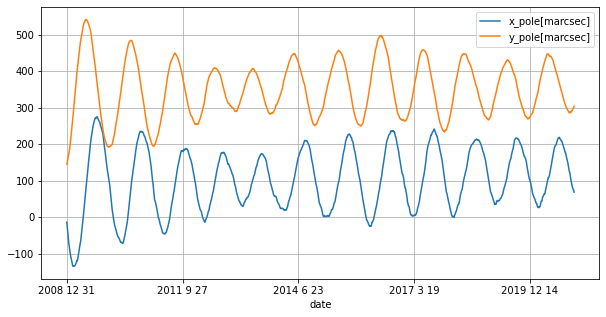

In [ ]:
df.plot(x='date',y=['x_pole[marcsec]','y_pole[marcsec]'], figsize=(10, 5), grid=True)


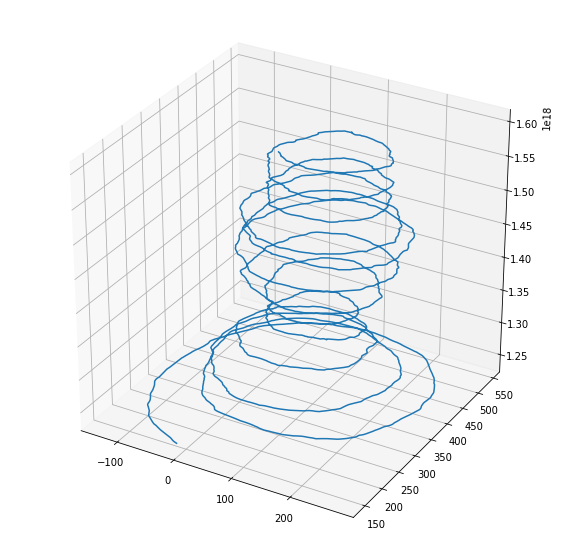

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(df['x_pole[marcsec]'],df['y_pole[marcsec]'],pd.to_datetime(df['date']))
plt.show()